Notebook for analyzing the results of a hyperparameter run.

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
import sys
import pickle
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import targprop.datasets as ds

# process the hyperparameter run

In [4]:
RUN = '../saves/170211_cl_tanh/'

In [5]:
# process directory information
data_files = [i for i in os.listdir(RUN) if i.endswith('.pickle') and 'params' not in i]
sim_nums = [i.replace('.pickle', '') for i in data_files]
param_files = [i+'params.pickle' for i in sim_nums]
assert len(data_files) == len(param_files)

total_sims = len(data_files)
print 'total sims: ', total_sims

total sims:  46


In [6]:
# start with the first file
data = pickle.load(open(RUN+data_files[0], 'rb'))
params = pickle.load(open(RUN+param_files[0], 'rb'))

err_algs = len(data)

In [7]:
# make each value a list entry
for i,j in params.items():
  params[i] = [j]
for k in range(err_algs):
  for i,j in data[k].items():
    data[k][i] = [j]

In [8]:
# now go through the rest
for i in range(1, total_sims):
  data_ = pickle.load(open(RUN+data_files[i], 'rb'))
  params_ = pickle.load(open(RUN+param_files[i], 'rb'))
  for i,j in params_.items():
    params[i].append(j)
  for k in range(err_algs):
    for i,j in data_[k].items():
      data[k][i].append(j)

In [9]:
for k in range(err_algs):
  for i in data[k].keys():
    data[k][i+str(k)] = data[k].pop(i)

In [10]:
df = pd.DataFrame(params)
for k in range(err_algs):
  df = df.join(pd.DataFrame(data[k]))

In [31]:
df.drop('l_dim', axis=1, inplace=True)

In [32]:
mnist = ds.mnist_data_test()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [33]:
def giant_regplot(df, logx=[]):
  col_set = df.columns
  for col in col_set:
    if len(df[col].unique())==1:
      df.drop(col, axis=1, inplace=True)
  cols = df.columns
  rows = df.columns
  
  isnumeric = [np.any([isinstance(i, (int, long, float, complex)) for i in df[c]]) for c in cols]  
  
  fact = 3
  num_cols = num_rows = len(cols)
  f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols, fact*num_rows), sharey=False, sharex=False)
  for ir, row in enumerate(rows):
    for ic, col,  in enumerate(cols):
      logx_bool = col in logx
      if logx_bool:
        ax[ir, ic].set_xscale('log', basex=10)
      logy_bool = row in logx
      if logy_bool:
        ax[ir, ic].set_yscale('log', basex=10)

      if np.logical_xor(isnumeric[ir], isnumeric[ic]):
        sns.violinplot(x=col, y=row, data=df, ax=ax[ir, ic])
      elif (isnumeric[ir] and isnumeric[ic]):
        sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
        d_range = df[row].max() - df[row].min()
        ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
        ax[ir, ic].set_xlim([df[col].min(), df[col].max()])

      if ir < num_rows-1:
        ax[ir, ic].xaxis.label.set_visible(False)
      if ic > 0:
        ax[ir, ic].yaxis.label.set_visible(False)



# classification

In [34]:
df.columns

Index([u'alpha_t', u'gamma', u'learning_rate', u'learning_rate_inv',
       u'noise_str', u'L_test0', u'accuracy_test0', u'L_test1',
       u'accuracy_test1', u'L_test2', u'accuracy_test2'],
      dtype='object')

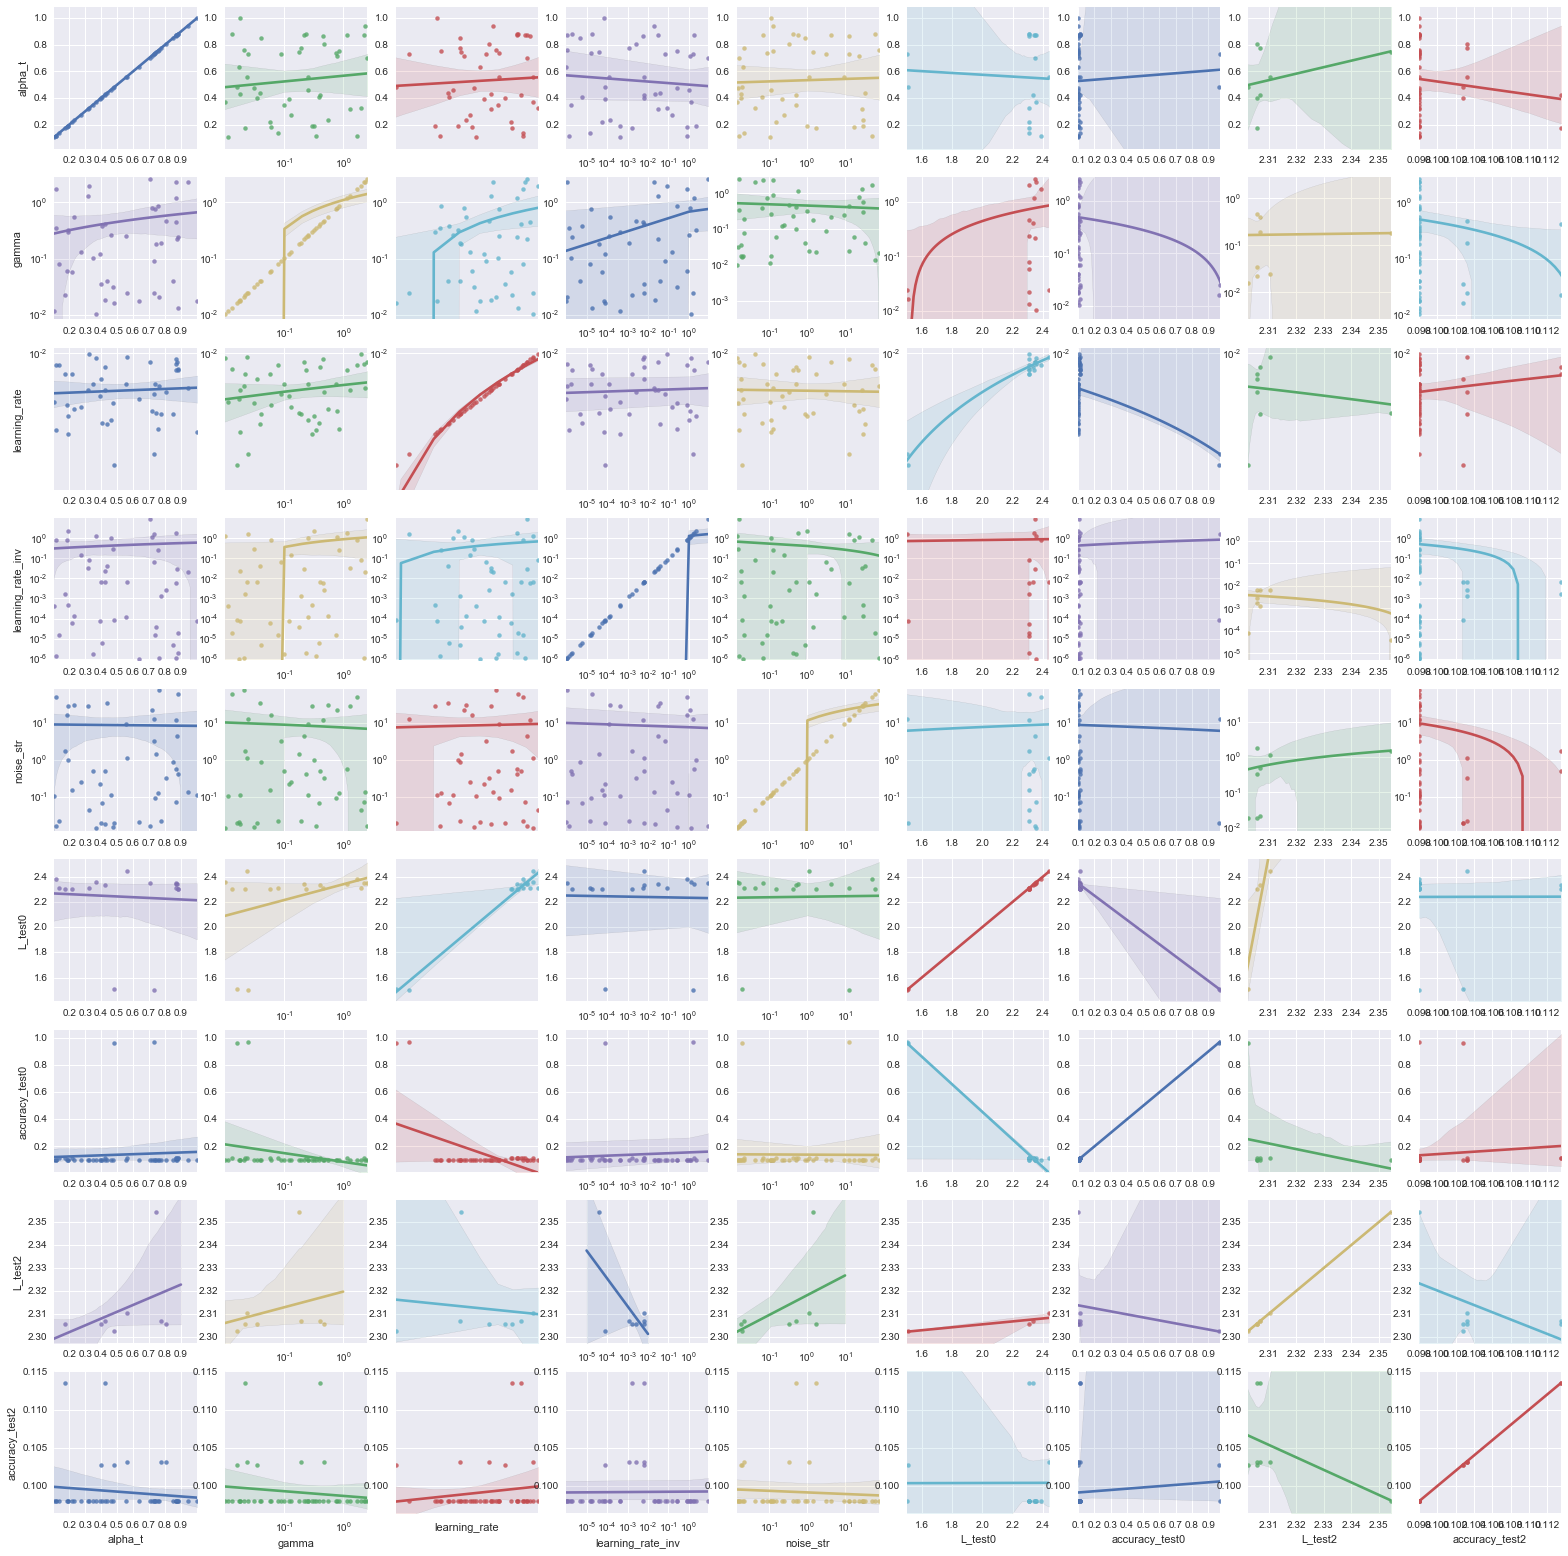

In [37]:
giant_regplot(df, logx=['gamma', 'learning_rate', 'learning_rate_inv', 'noise_str'])

# autoencoder


In [85]:
df = df[df['L_test1'] < 0.2]
df = df[df['L_test2'] < 0.1]

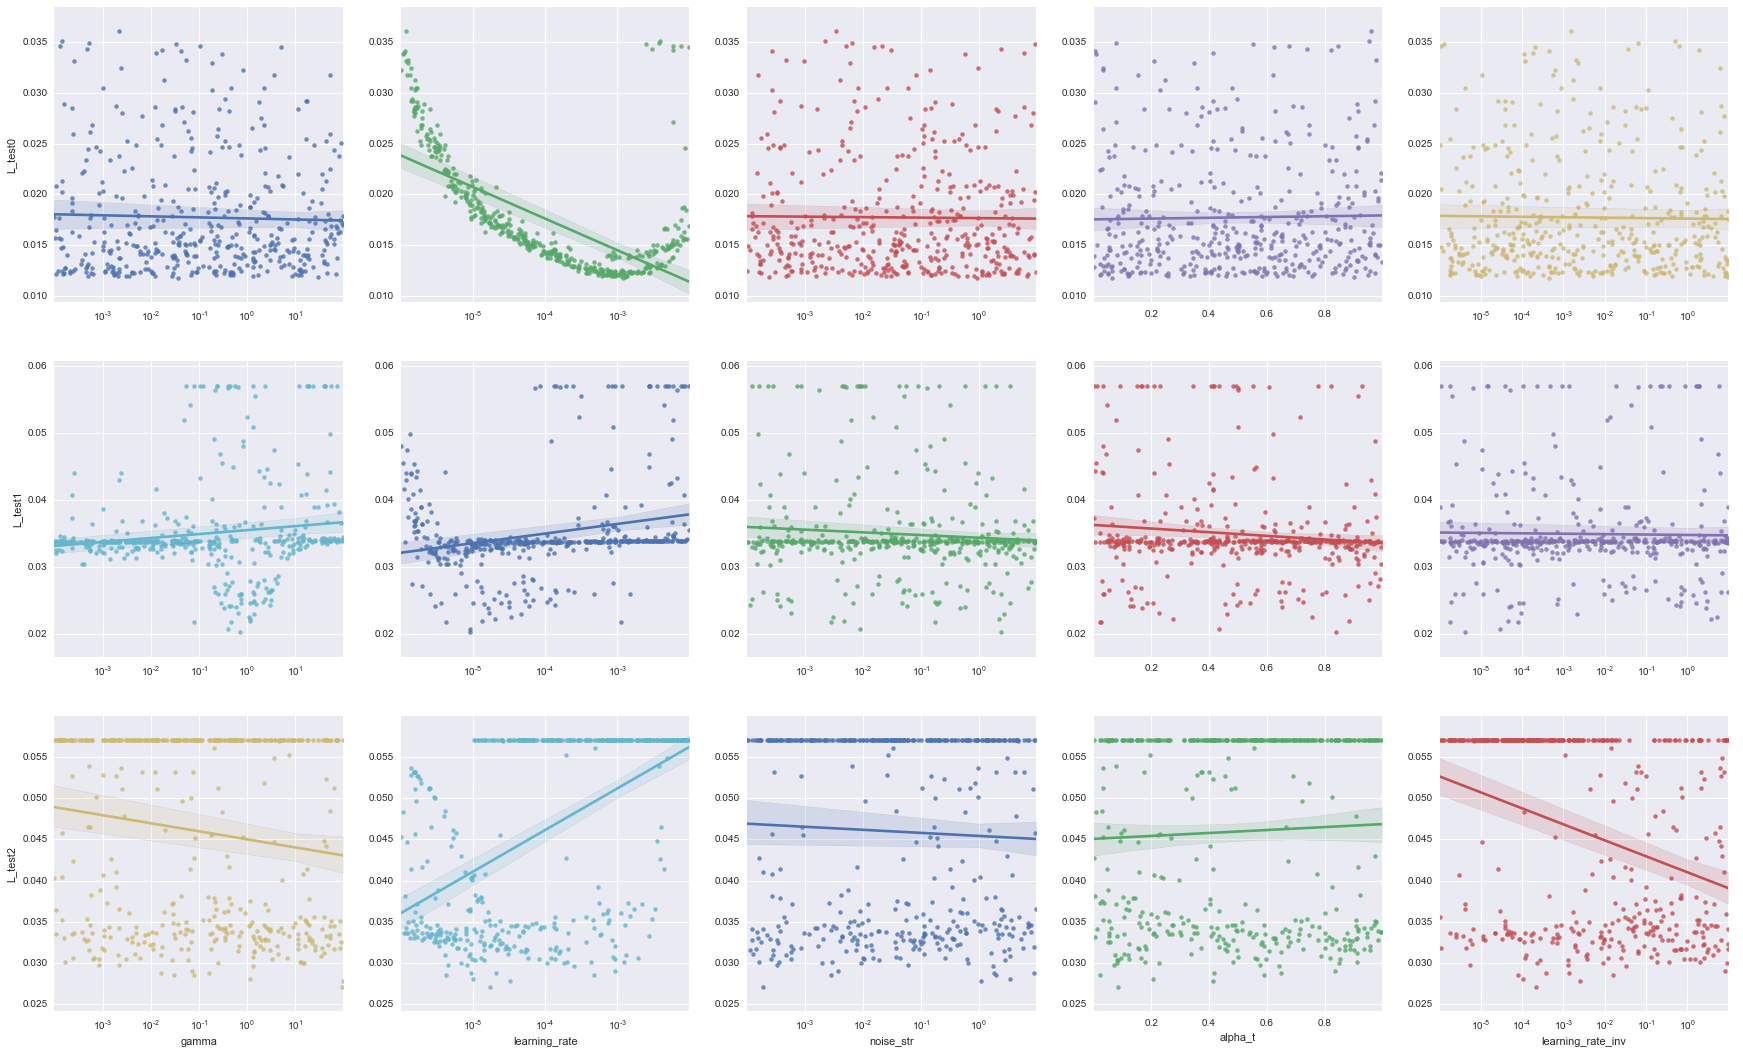

In [86]:
rows = [u'L_test0', u'L_test1', u'L_test2']

exclude = ['batch_size', 'l_dim', 'actvs2', 'actvs1', 'actvs0']
cols = list(set(df.columns) - set(rows) - set(exclude)) # everything else

logx = [u'gamma', u'learning_rate', u'learning_rate_inv', u'noise_str'] # which cols get a log xscale

num_cols = len(cols)
num_rows = len(rows)

fact = 6
f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols,fact*num_rows), sharey=False, sharex=False)

for ir, row in enumerate(rows):
  for ic, col,  in enumerate(cols):
    logx_bool = col in logx
    if logx_bool:
      ax[ir, ic].set_xscale('log', basex=10)
    sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
    if ir < num_rows-1:
      ax[ir, ic].xaxis.label.set_visible(False)
    if ic > 0:
      ax[ir, ic].yaxis.label.set_visible(False)
      
    d_range = df[row].max() - df[row].min()
    ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
    ax[ir, ic].set_xlim([df[col].min(), df[col].max()])
      
plt.show()

In [70]:
ind0 = df['L_test0'].argmin()
ind1 = df['L_test1'].argmin()
ind2 = df['L_test2'].argmin()

In [74]:
df['actvs0'][ind0].shape

(20, 784)

In [80]:
df['actvs0'][ind0]

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ..., 
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

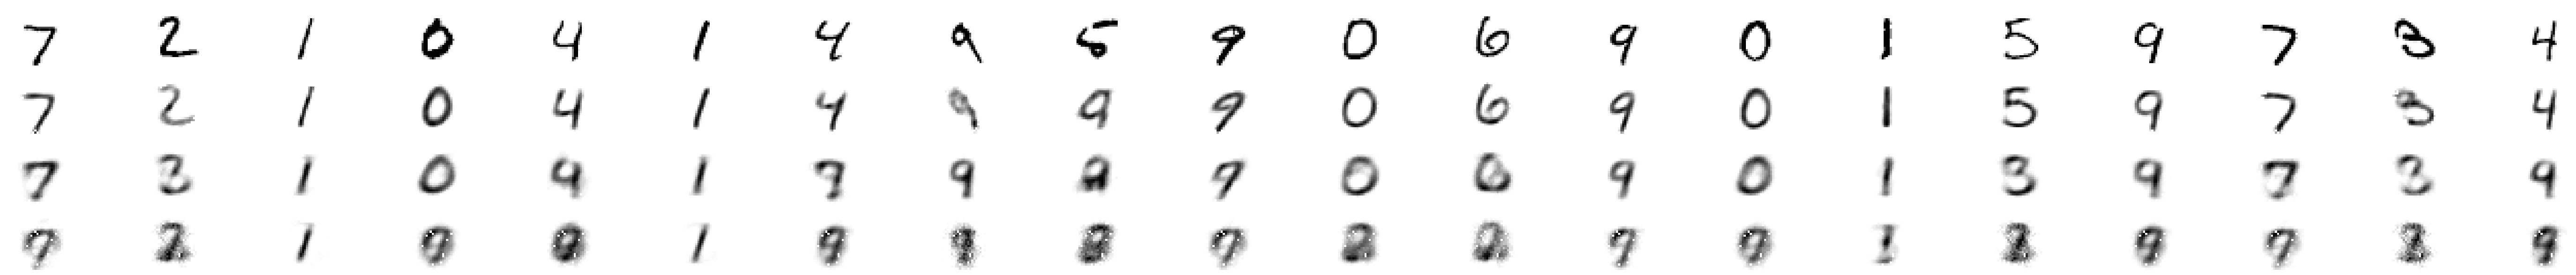

In [84]:
n = 20
f, ax = plt.subplots(4, n, figsize=(5*n,5*2))
np.random.seed(4)
for col, i in enumerate(range(n)):
  example = np.random.randint(df['actvs0'][0].shape[0])
  example = i
  ax[0, col].matshow(mnist.inputs[example].reshape((28,28)))
  ax[1, col].matshow(df['actvs0'][ind0][example].reshape((28,28)))
  ax[2, col].matshow(df['actvs1'][ind1][example].reshape((28,28)))
  ax[3, col].matshow(df['actvs2'][ind2][example].reshape((28,28)))
  ax[0, col].axis('off')
  ax[1, col].axis('off')
  ax[2, col].axis('off')
  ax[3, col].axis('off')
plt.show()
